In [1]:
import simsz.make_dm_halo as make_dm_halo
import simsz.utils as utils
from simsz import simtools, noise, filters
import make_sz_cluster
import simsz.load_vars as load_vars
from colossus.halo import mass_adv
import matplotlib.pyplot as plt

import time
from datetime import datetime as dt
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
from pixell import enmap, powspec, enplot
import camb
#import healpy
import scipy

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

First let's select some boxes to cut out of ACT temperature and inverse variance maps so we don't need to load in the whole things. The limits are chosen based on the coverage of our confirmed cluster cooridinates (listed later). Then we plot the map and the inverse variance map.

In [2]:
# # Set the size of the box in degrees and convert to radians to load in only part of these maps
dec_from, dec_to = np.deg2rad([-4,4])
ra_from, ra_to = np.deg2rad([-1, 45])

# # Create the box
box = [[dec_from,ra_from],[dec_to,ra_to]]

# # read in the map
# imap = enmap.read_map(path + "act_planck_dr5.01_s08s18_AA_f150_night_map.fits", box = box)[0]

img=enmap.read_map("act_dr5.01_s08s18_AA_f150_daynight_map.fits",box=box)[0]
ivar=enmap.read_map("act_dr5.01_s08s18_AA_f150_daynight_ivar.fits",box=box)[0]

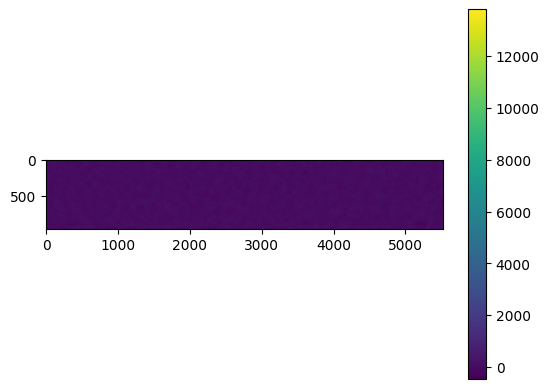

In [3]:
#This is the map
im=plt.imshow(img)
cbar = plt.colorbar(im)

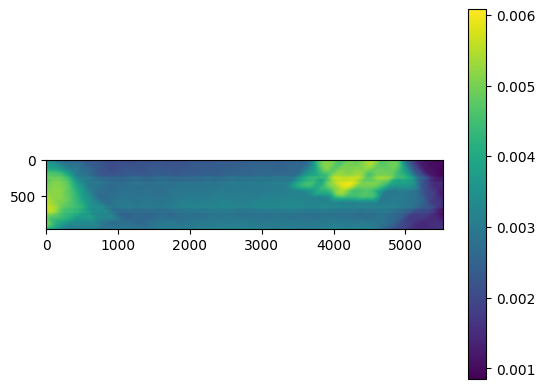

In [4]:
#This is the noise map
im2=plt.imshow(ivar)
cbar = plt.colorbar(im2)

Now let's define a function to cut submaps out of the maps. We will use this to make submaps centered on our galaxy clusters.

In [ ]:
def plotsubmap_w_radec(ra_in,dec_in,maptype): #Define a function to plot a submap
    dec,ra = np.deg2rad([dec_in,ra_in]) 
    # Give the box a width of 10 arcmin
    W = 0.325
    width = np.deg2rad(0.325)
    # Create the box and use it to select a submap
    box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
    if maptype=='map':
        submap=img.submap(box) #From temperature map
    if maptype=='ivar':
        submap=ivar.submap(box) #From noise map (inverse variance)
    im3=plt.imshow(submap)
    cbar = plt.colorbar(im3)

The following data is a list of RA, DEC, z, and M information for 30 confirmed clusters from ACT data (arXiv:1301.0816). We can look at these clusters in the ACT data and then also simulate them based on these inputs.

In [6]:
#Make array of confirmed clusters for stacking from arXiv:1301.0816 (first 30)
rac=[2.0418,3.0152,3.7276,4.4138,4.5623,5.5553,6.5699,11.1076,11.3051,12.7875,14.5189,14.7855,16.2195,19.9971,21.8227,24.8407,28.1764,29.1008,31.5567,33.8699,34.5626,34.9533,34.9759,35.3925,35.7939,37.1250,37.7273,39.9718,40.0102,40.3129]
decc=[2.0204,-0.7693,-0.9502,-0.858,-0.3795,-0.605,1.3367,1.2221,-1.8827,0.9323,0.5106,-0.8326,0.0495,0.9193,0.3468,-1.4769,1.0059,-1.3879,-1.2428,0.5091,-0.6883,0.3755,1.4973,-0.2063,-0.9466,0.5033,-0.4043,-1.5758,1.2693,-0.3109]
zc=[0.36,1.36,0.533,0.211,0.75,0.805,0.65,1.11,0.545,0.69,0.76,0.786,0.277,0.72,0.379,0.70,0.230,0.45,0.676,0.865,0.672,0.537,0.35,0.589,0.663,0.72,0.44,0.375,0.62,0.684]
mc_500=[3.9,3.0,5.7,2.9,3.1,5.5,4.4,2.7,5.6,2.2,3.2,5.2,2.6,3.3,3.3,2.1,5.7,3.1,4.3,3.5,3.8,3.0,2.8,1.4,3.8,2.4,2.8,6.7,3.3,2.5]
mc_500=[x*1e14 for x in mc_500]
mc_b12=[5.2,3.9,7.6,3.9,4.0,7.3,5.8,3.5,7.5,2.8,4.1,6.9,3.5,4.3,4.4,2.6,7.9,4.0,5.7,4.5,4.9,3.9,3.7,1.8,5.0,3.0,3.7,9.1,4.3,3.2]
mc_b12=[x*1e14 for x in mc_b12]

Let's look at one of these clusters and the associated inverse variance map.

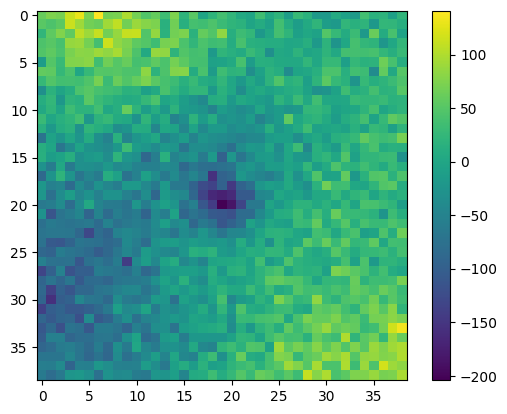

In [7]:
plotsubmap_w_radec(rac[5],decc[5],'map') #plot one of these confirmed cluster submaps

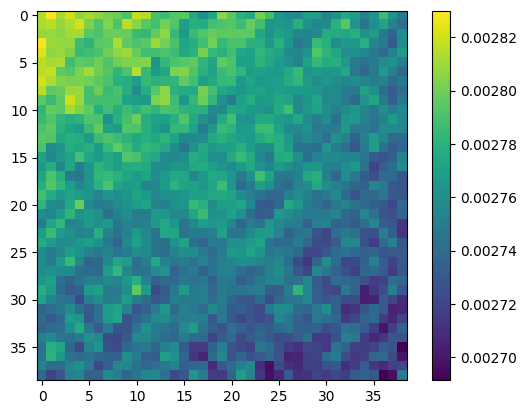

In [8]:
plotsubmap_w_radec(rac[5],decc[5],'ivar') #plot the associated inverse variance submap

Now let's average together the 30 clusters to eventually compare to simulations. We'll do this by defining a new stacking function to average together the submaps. Then we call it for the temperature and the noise maps.

Text(0.5, 1.0, '30 Conf. Clusters, ACT DR4')

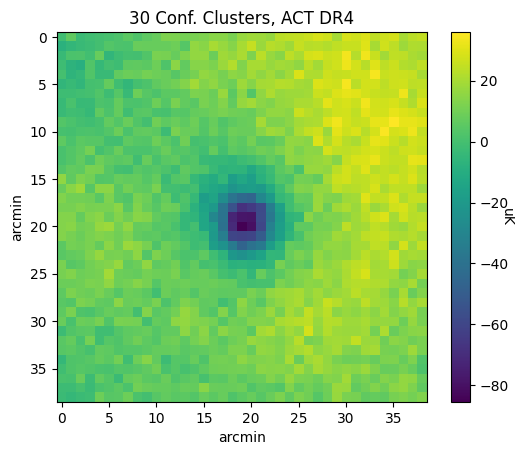

In [113]:
def stack(ra_array, box_width_radians, map_for_cutout):
    for i in range(len(ra_array)): 
        dec,ra = np.deg2rad([decc[i],ra_array[i]]) 
        box = [[dec-box_width_radians/2.,ra-box_width_radians/2.],[dec+box_width_radians/2.,ra+box_width_radians/2.]]
        submap=map_for_cutout.submap(box)
        if i==0:
            submaptot=submap
        if i>0:
            submaptot+=submap
    submaptot=submaptot/(len(ra_array))
    return submaptot
        

act_stack=stack(rac,np.deg2rad(0.325),img) # Give the box a width of 19.5 arcmin 
im3=plt.imshow(act_stack)
cbar = plt.colorbar(im3)
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('uK', rotation=270)
plt.title('30 Conf. Clusters, ACT DR4')

#Plot a stack of these 30 clusters to compare to our sims. This is what the average map looks like:

Text(0.5, 1.0, '30 Conf. Clusters, ACT DR4 Noise Map')

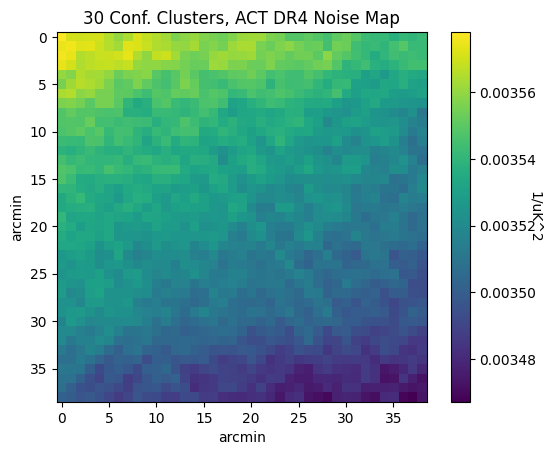

In [114]:
act_ivar_stack=stack(rac,np.deg2rad(0.325),ivar) # Give the box a width of 19.5 arcmin 
im3=plt.imshow(act_ivar_stack)
cbar = plt.colorbar(im3)
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('1/uK^2', rotation=270)
plt.title('30 Conf. Clusters, ACT DR4 Noise Map')

#Plot a stack of the ivar submaps for the 30 clusters to determine our noise level. This is what the average map looks like:

Now let's do some aperture photometry. The AP result from the temperature map we'll compare to our sims, and the AP result from the noise map will inform our white noise setting for our sims.

Average in inner radius: -39.593124
Average in outer radius: -7.0827923
tSZ signal: -32.51033


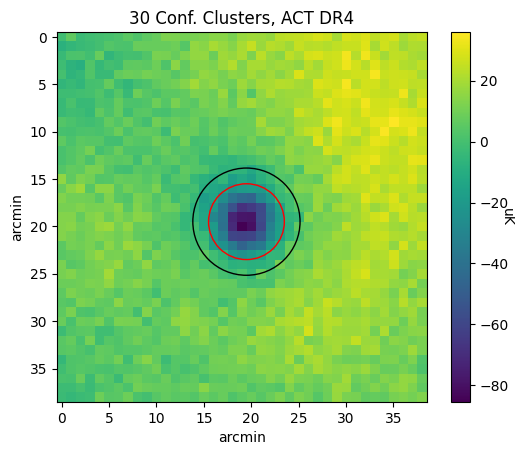

In [133]:
#AP on this stack

aperture=4 #arcmin
submap_stack=act_stack

disk, ring, signal = filters.get_tSZ_signal_aperture_photometry(submap_stack, aperture)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(submap_stack.shape) / 2
#center = [trunc(x) for x in center]
#center = center - center[0]
fig, ax = plt.subplots()
im=ax.imshow(submap_stack)
disk_circle = plt.Circle(center, aperture, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, aperture * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
cbar = plt.colorbar(im)
ax.set_ylabel('arcmin')
ax.set_xlabel('arcmin')
cbar.set_label('uK', rotation=270)
ax.set_title('30 Conf. Clusters, ACT DR4')
plt.show()

Average in inner radius: 0.0035207325
Average in outer radius: 0.0035213209
tSZ signal: -5.8836304e-07


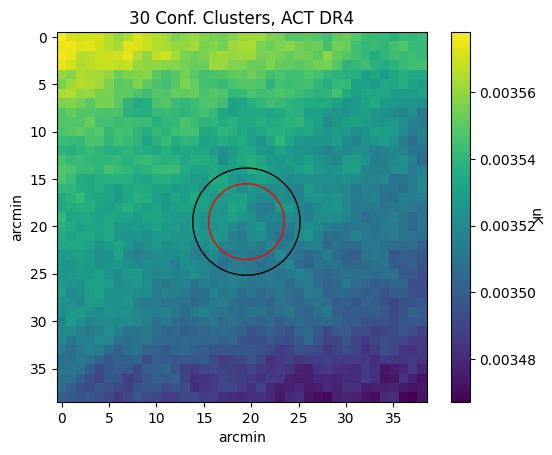

In [119]:
aperture=4 #arcmin
submap_stack=act_ivar_stack

disk, ring, signal = filters.get_tSZ_signal_aperture_photometry(submap_stack, aperture)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(submap_stack.shape) / 2
#center = center - center[0]
fig, ax = plt.subplots()
im=ax.imshow(submap_stack)
disk_circle = plt.Circle(center, aperture, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, aperture * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
cbar = plt.colorbar(im)
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('uK', rotation=270)
plt.title('30 Conf. Clusters, ACT DR4')
plt.show()

The average noise value at the center of this submap stack is <ivar>=0.00352 uK^-2. Converting this to uK arcmin via (sqrt(<ivar>)^-1 * 0.5 arcmin = 8.43 uK*arcmin which I will use in the input yaml to generate the white noise level for the simulated submaps.

In [13]:
clusters = make_sz_cluster.simulate_submap(mc_b12, zc) #Try a sim set of these masses and redshifts with noise level 8.43 uK*arcmin

In [14]:
#Load the saved simset

filename='outfiles/sz_sim_230914140304725912_150_950292.h5'
f= h5py.File(filename)

keys=list(f.keys())

sims=[f[key]['final_map'] for key in keys]

Now let's stack our simulated clusters.

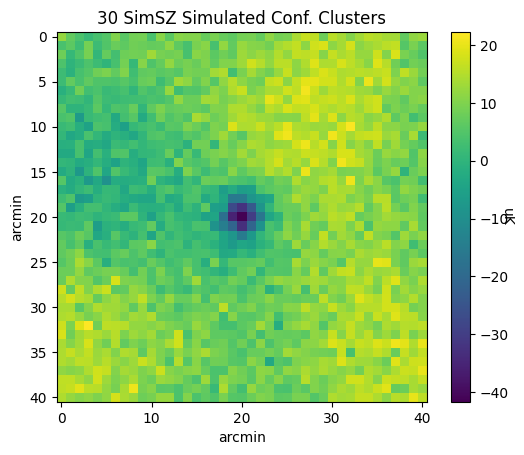

In [120]:
#Plot the stacked sims

simstot=np.zeros(np.shape(sims[0]))
for i in range(len(sims)):
    simstot+=sims[i]
    
simstot=simstot/(len(sims))
im3=plt.imshow(simstot)
cbar = plt.colorbar(im3)
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('uK', rotation=270)
plt.title('30 SimSZ Simulated Conf. Clusters')
plt.show()

Now let's do AP on this stack to compare to the ACT DR4 data.

Average in inner radius: -8.723956623227396
Average in outer radius: 4.396444993927489
tSZ signal: -13.120401617154887
[20.0, 20.0]


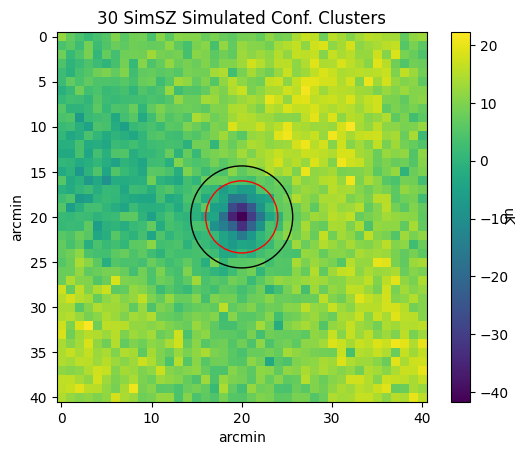

In [129]:
aperture=4 #arcmin
submap_stack=simstot

disk, ring, signal = filters.get_tSZ_signal_aperture_photometry(simstot, aperture)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(simstot.shape) / 2
center = [np.round(x,0) for x in center]
print(center)#center = center - center[0]
fig, ax = plt.subplots()
im=ax.imshow(simstot)
disk_circle = plt.Circle(center, aperture, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, aperture* np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
cbar = plt.colorbar(im)
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('uK', rotation=270)
plt.title('30 SimSZ Simulated Conf. Clusters')
plt.show()

Now let's compare the radial profiles of the ACT DR4 stacked submaps and the simulated confirmed cluster submaps.

In [122]:
def radial_profile(data, center): #Defining a function to take radial profile
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

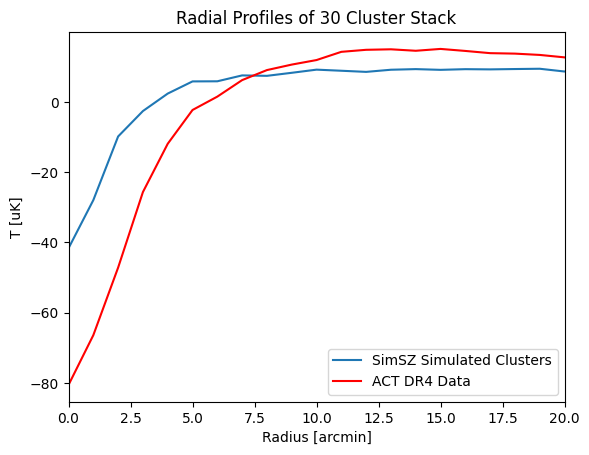

In [127]:
simp=radial_profile(simstot,[20,20])
actp=radial_profile(submaptot_confclust,[20,20])

plt.plot(simp,label='SimSZ Simulated Clusters')
plt.plot(actp,'r',label='ACT DR4 Data')
plt.ylabel('T [uK]')
plt.xlabel('Radius [arcmin]')
plt.xlim(0,20)
plt.title('Radial Profiles of 30 Cluster Stack')
plt.legend()

In [123]:
r

NameError: name 'r' is not defined